In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import warnings


from torchsummary import summary
from pthflops import count_ops
warnings.filterwarnings('ignore')


torch.cuda.empty_cache()

In [2]:
#!unzip /content/Natural-Faces.zip                                         # CODE TO MOVE IMAGES FROM ONE FOLDER TO ANOTHER
# import os, random
# import shutil

# m=10

# src_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/train/contempt/"
# dst_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/test/contempt/"

# file_list = os.listdir(src_dir)

# for i in range(m):
    
#     a = random.choice(file_list)
#         #file_list.remove(a)
#     shutil.move(src_dir + a, dst_dir+ a)

In [3]:
def load_data(train_path, test_path, batch_size,input_size,mn,sd,shuffle_test=False):
    
    ######## Write your code here ########
    transform_dict={"src":transforms.Compose([transforms.Resize(size=input_size),transforms.RandomHorizontalFlip(),transforms.RandomAdjustSharpness(sharpness_factor=0.3),
            transforms.RandomVerticalFlip(),transforms.ToTensor(),transforms.Normalize(mean=mn,std=sd)])}

    train=datasets.ImageFolder(root=train_path,transform=transform_dict["src"],)
    
    
    labelslist=train.class_to_idx
    dataset_size = len(train)
    
    train_size = int(round(0.85 * dataset_size))
    val_size = int(round(0.15 * dataset_size))
    

    train_dataset,val_dataset = torch.utils.data.random_split(train,[train_size,val_size])
    test_dataset=datasets.ImageFolder(root=test_path,transform=transform_dict["src"])
    
    

    print('Size Of Train Dataset',len(train_dataset))
    print('Size Of Test Dataset',len(test_dataset))
    print('Size Of Validation Dataset',len(val_dataset))
   

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
 
      
    return data_loader_train, data_loader_test,data_loader_val,labelslist

In [4]:
# model1=models.resnet50(weights=True)               # FINDING NO OF LAYERS IN A MODEL AND DISPLAYING THEM
# ct=0
# for child in model1.children():
#     ct+=1
#     print('--------------')
#     print(child)
# print(ct)


model_vgg_frozen = models.vgg16(weights=True)         # CREATING MODELS FREEZING ALL THE LAYERS EXCEPT THE FC LAYER
ct = 0
for child in model_vgg_frozen.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False
            
model_resnet_frozen = models.resnet50(weights=True)
ct = 0
for child in model_resnet_frozen.children():
    ct += 1
    if ct < 10:
        for param in child.parameters():
            param.requires_grad = False

In [5]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  

# Natural Faces: 
	
# M: [0.5236, 0.5236, 0.5236]
# SD:[0.2351, 0.2351, 0.2351]


# Tiny:

# M: [0.5422, 0.4674, 0.4349]
# SD: [0.2665, 0.2500, 0.2517]

# Masked-Fer2013:

# M: [0.4652, 0.5198, 0.5736]
# SD: [0.2354, 0.2363, 0.2666]


In [6]:
def img_show(train_loader,lablist):

    
    
    images,labels=next(iter(train_loader))
    
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    print(lablist)
    
    figure = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3             #Displays 9 images in a 3*3 grid
    for i in range(1, cols * rows + 1):

        img = images[i].squeeze()
        img_label = labels[i]
        
        label=(list(lablist.keys())[list(lablist.values()).index(img_label)])
        
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    



In [7]:
def grp_show(x,y,label,col,x_label,y_label,title,path):
    
    for i in range(0,len(y)):
      plt.plot(x, y[i], col[i], label=label[i])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.savefig(f'{path}{title}.jpg')
    
    plt.show()
 


In [8]:
def train_model(num_epochs,train_loader,val_loader):
    model.train()
    Train_steps = len(train_loader)
    Val_steps=len(val_loader)
    print('Total Steps',Train_steps)
    t1 = time.time()

    acclist_train=[]
    acclist_val=[]
    losslist_train=[]
    losslist_val=[]
    epc=[]
    cons_epchs=0
    loss_criteria=0.0001
    last_loss=np.Inf
    verbose=10
    

    for epoch in range(num_epochs):
        
        # exp_lr_scheduler.step()
        # print('Epoch:', epoch+1,'LR:', exp_lr_scheduler.get_lr())
        
        
        correct=0
        total=0
        loss_train=0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)#Feedforward
            loss = criterion(outputs, labels)
            optimizer.zero_grad()#Gradient
            loss.backward()#Weights update
            optimizer.step()

            total+= labels.size(0) 

            _,predicted = torch.max(outputs.data, 1) #1 so that all the data is on the same line

            correct+= (predicted == labels).sum().item()
            loss_train+=loss.item()
            if (i + 1)  == Train_steps:

                  correct_v = 0                                                 #Validation Loop
                  total_v = 0
                  loss_v=0
                  for dataVal in val_loader:
                      images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                      outputs_v = model(images_v)
                      loss=criterion(outputs_v,labels_v)
                      _, predicted_v = torch.max(outputs_v.data, 1)
                      correct_v += (predicted_v == labels_v).sum().item()
                      total_v += labels_v.size(0)
                      loss_v+=loss.item()
              
                  print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.4f},'
                      .format(epoch + 1, num_epochs, loss_train/Train_steps, loss_v/Val_steps, (correct / total) * 100, (correct_v / total_v) * 100))
                  
                  acclist_train.append((correct / total) * 100)
                  acclist_val.append((correct_v / total_v) * 100)
                  losslist_train.append(loss_train/Train_steps)
                  losslist_val.append(loss_v/Val_steps)
                  epc.append(epoch+1)

                  
                  
                  current_loss=loss_v/Val_steps

                  if (last_loss-current_loss)<=loss_criteria:
                      cons_epchs += 1
                      last_loss = current_loss
                      
                      if cons_epchs >= verbose:
                        print('Loss Did Not Improve by more than 0.0001 for 10 epochs..Stopping')
                        print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
                        return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

                  else:
                    cons_epchs = 0

                  

 
    time_taken=time.time()-t1
    print("######## Training Finished in {} seconds ###########".format(time_taken))
    return model,acclist_train,acclist_val,losslist_train,losslist_val,epc,time_taken

In [9]:
from torch.cuda import device
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model,test_loader):
    model.eval() 

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        
        
        print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        ConfusionMatrixDisplay(conf_mat).plot()
        plt.show()

Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


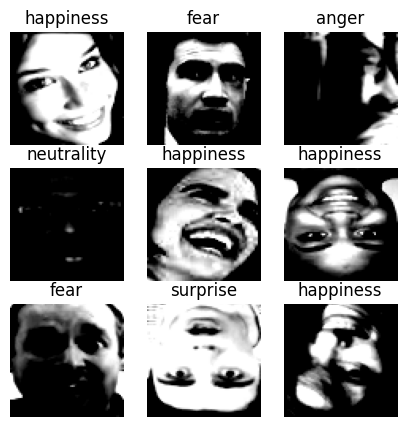

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.5389, Validation Loss: 2.0914, Training Accuracy: 16.39%, Validation Accuracy: 18.8841,
Epoch [2/150], Training Loss: 2.0668, Validation Loss: 2.0177, Training Accuracy: 20.06%, Validation Accuracy: 20.7439,
Epoch [3/150], Training Loss: 2.0175, Validation Loss: 1.9238, Training Accuracy: 22.25%, Validation Accuracy: 26.1803,
Epoch [4/150], Training Loss: 1.9020, Validation Loss: 1.9192, Training Accuracy: 27.05%, Validation Accuracy: 27.3247,
Epoch [5/150], Training Loss: 1.8419, Validation Loss: 1.8474, Training Accuracy: 30.56%, Validation Accuracy: 33.3333,
Epoch [6/150], Training Loss: 1.7738, Validation Loss: 1.7756, Training Accuracy: 34.68%, Validation Accuracy: 35.9084,
Epoch [7/150], Training Loss: 1.7143, Validation Loss: 1.7686, Training Accuracy: 37.66%, Validation Accuracy: 35.9084,
Epoch [8/150], Training Loss: 1.6555, Validation Loss: 1.6788, Training Accuracy: 39.40%, Validation Accuracy: 38.3405,
Epoch [9/1

Epoch [69/150], Training Loss: 0.0964, Validation Loss: 2.7776, Training Accuracy: 96.59%, Validation Accuracy: 51.0730,
Epoch [70/150], Training Loss: 0.0838, Validation Loss: 2.8594, Training Accuracy: 97.68%, Validation Accuracy: 48.7840,
Epoch [71/150], Training Loss: 0.1114, Validation Loss: 2.7927, Training Accuracy: 96.69%, Validation Accuracy: 50.0715,
Epoch [72/150], Training Loss: 0.1019, Validation Loss: 2.7888, Training Accuracy: 97.04%, Validation Accuracy: 53.2189,
Epoch [73/150], Training Loss: 0.0973, Validation Loss: 2.6254, Training Accuracy: 96.72%, Validation Accuracy: 51.5021,
Epoch [74/150], Training Loss: 0.0972, Validation Loss: 2.8469, Training Accuracy: 96.92%, Validation Accuracy: 51.7883,
Epoch [75/150], Training Loss: 0.0960, Validation Loss: 2.7716, Training Accuracy: 96.77%, Validation Accuracy: 49.4993,
Epoch [76/150], Training Loss: 0.1142, Validation Loss: 2.9864, Training Accuracy: 96.41%, Validation Accuracy: 48.6409,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0410, Validation Loss: 3.5195, Training Accuracy: 98.43%, Validation Accuracy: 52.6466,
Epoch [138/150], Training Loss: 0.0793, Validation Loss: 3.3104, Training Accuracy: 97.32%, Validation Accuracy: 50.6438,
Epoch [139/150], Training Loss: 0.0923, Validation Loss: 3.1740, Training Accuracy: 97.02%, Validation Accuracy: 50.7868,
Epoch [140/150], Training Loss: 0.0785, Validation Loss: 2.9143, Training Accuracy: 97.37%, Validation Accuracy: 52.7897,
Epoch [141/150], Training Loss: 0.0566, Validation Loss: 3.1674, Training Accuracy: 98.06%, Validation Accuracy: 50.3577,
Epoch [142/150], Training Loss: 0.0548, Validation Loss: 3.2719, Training Accuracy: 98.21%, Validation Accuracy: 49.7854,
Epoch [143/150], Training Loss: 0.0593, Validation Loss: 3.1234, Training Accuracy: 97.70%, Validation Accuracy: 52.3605,
Epoch [144/150], Training Loss: 0.0686, Validation Loss: 3.1812, Training Accuracy: 97.75%, Validation Accuracy: 51.2160,
Epoch [145/150], Trainin

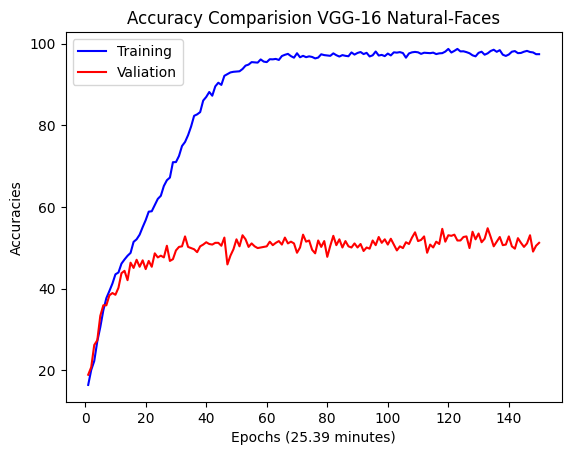

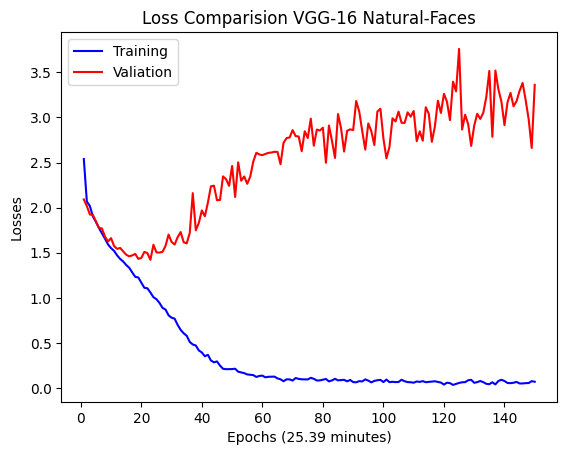

Test Accuracy of the model on the 900 test images: 55.111111111111114 %


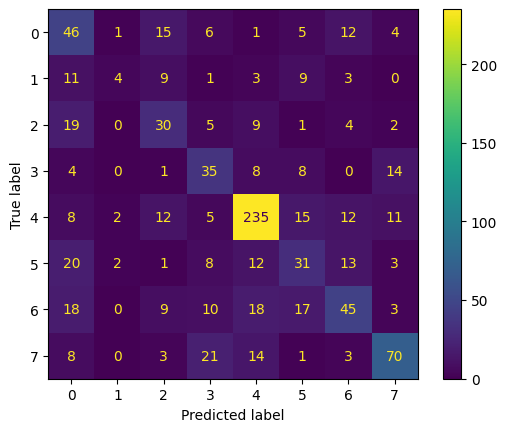

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


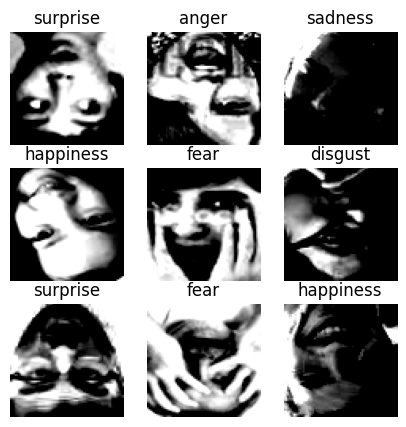

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.6260, Validation Loss: 2.0324, Training Accuracy: 20.11%, Validation Accuracy: 21.4592,
Epoch [2/150], Training Loss: 1.9475, Validation Loss: 1.9909, Training Accuracy: 24.98%, Validation Accuracy: 22.7468,
Epoch [3/150], Training Loss: 1.9271, Validation Loss: 1.9555, Training Accuracy: 25.44%, Validation Accuracy: 22.7468,
Epoch [4/150], Training Loss: 1.9040, Validation Loss: 1.9571, Training Accuracy: 26.70%, Validation Accuracy: 22.7468,
Epoch [5/150], Training Loss: 1.9084, Validation Loss: 1.9481, Training Accuracy: 25.89%, Validation Accuracy: 24.1774,
Epoch [6/150], Training Loss: 1.8589, Validation Loss: 1.9226, Training Accuracy: 29.50%, Validation Accuracy: 27.3247,
Epoch [7/150], Training Loss: 1.8490, Validation Loss: 1.9498, Training Accuracy: 29.65%, Validation Accuracy: 24.7496,
Epoch [8/150], Training Loss: 1.8238, Validation Loss: 1.9020, Training Accuracy: 30.92%, Validation Accuracy: 26.1803,
Epoch [9/1

Epoch [69/150], Training Loss: 0.2514, Validation Loss: 2.9493, Training Accuracy: 92.04%, Validation Accuracy: 40.6295,
Epoch [70/150], Training Loss: 0.2659, Validation Loss: 3.1233, Training Accuracy: 91.46%, Validation Accuracy: 39.3419,
Epoch [71/150], Training Loss: 0.2250, Validation Loss: 2.9714, Training Accuracy: 92.83%, Validation Accuracy: 36.3376,
Epoch [72/150], Training Loss: 0.2382, Validation Loss: 3.1353, Training Accuracy: 92.14%, Validation Accuracy: 37.9113,
Epoch [73/150], Training Loss: 0.2167, Validation Loss: 3.2016, Training Accuracy: 93.08%, Validation Accuracy: 36.1946,
Epoch [74/150], Training Loss: 0.2255, Validation Loss: 3.0297, Training Accuracy: 92.73%, Validation Accuracy: 38.7697,
Epoch [75/150], Training Loss: 0.2147, Validation Loss: 3.1579, Training Accuracy: 93.28%, Validation Accuracy: 41.0587,
Epoch [76/150], Training Loss: 0.2260, Validation Loss: 3.1694, Training Accuracy: 93.26%, Validation Accuracy: 37.0529,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.1352, Validation Loss: 3.9289, Training Accuracy: 95.20%, Validation Accuracy: 37.0529,
Epoch [138/150], Training Loss: 0.1321, Validation Loss: 3.7083, Training Accuracy: 95.48%, Validation Accuracy: 40.0572,
Epoch [139/150], Training Loss: 0.1153, Validation Loss: 3.8296, Training Accuracy: 96.44%, Validation Accuracy: 40.0572,
Epoch [140/150], Training Loss: 0.1157, Validation Loss: 3.6871, Training Accuracy: 96.03%, Validation Accuracy: 38.4835,
Epoch [141/150], Training Loss: 0.1185, Validation Loss: 3.7415, Training Accuracy: 96.39%, Validation Accuracy: 39.6280,
Epoch [142/150], Training Loss: 0.1165, Validation Loss: 3.8621, Training Accuracy: 95.86%, Validation Accuracy: 40.4864,
Epoch [143/150], Training Loss: 0.1149, Validation Loss: 3.8114, Training Accuracy: 96.46%, Validation Accuracy: 40.6295,
Epoch [144/150], Training Loss: 0.0852, Validation Loss: 3.8959, Training Accuracy: 97.32%, Validation Accuracy: 39.6280,
Epoch [145/150], Trainin

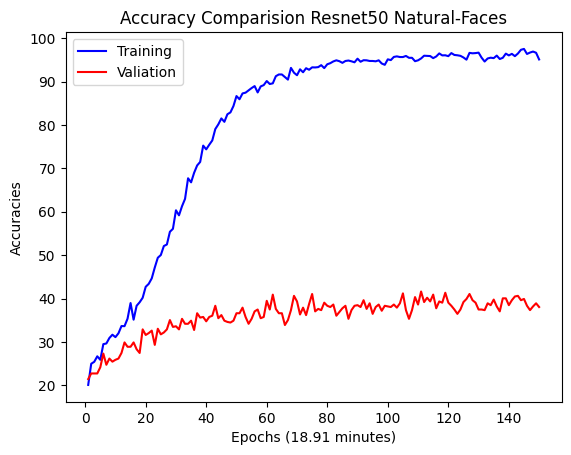

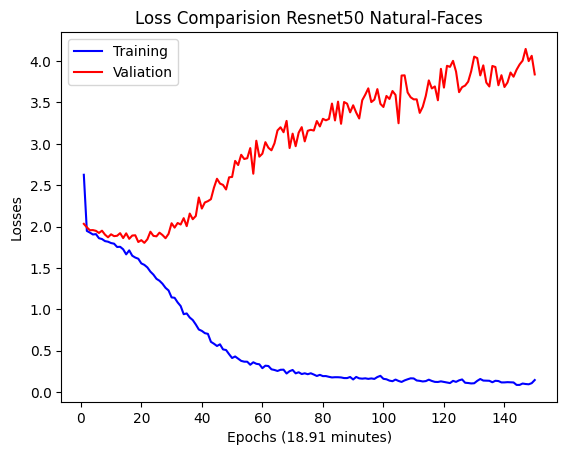

Test Accuracy of the model on the 900 test images: 43.44444444444445 %


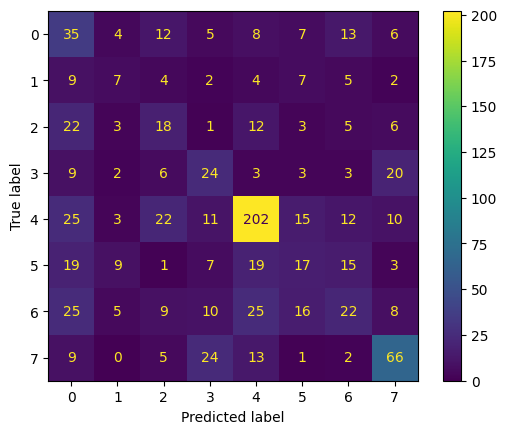

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


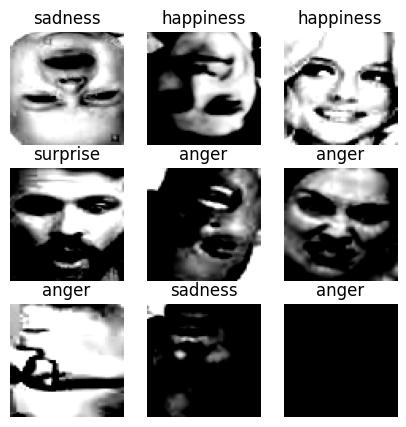

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.5396, Validation Loss: 2.0290, Training Accuracy: 18.92%, Validation Accuracy: 18.1688,
Epoch [2/150], Training Loss: 2.0092, Validation Loss: 2.0034, Training Accuracy: 21.62%, Validation Accuracy: 20.6009,
Epoch [3/150], Training Loss: 1.9747, Validation Loss: 1.9791, Training Accuracy: 22.78%, Validation Accuracy: 23.7482,
Epoch [4/150], Training Loss: 1.9380, Validation Loss: 1.9091, Training Accuracy: 25.69%, Validation Accuracy: 27.6109,
Epoch [5/150], Training Loss: 1.8635, Validation Loss: 1.8745, Training Accuracy: 29.63%, Validation Accuracy: 29.6137,
Epoch [6/150], Training Loss: 1.8358, Validation Loss: 1.8347, Training Accuracy: 29.83%, Validation Accuracy: 30.7582,
Epoch [7/150], Training Loss: 1.7533, Validation Loss: 1.7470, Training Accuracy: 34.12%, Validation Accuracy: 36.3376,
Epoch [8/150], Training Loss: 1.7100, Validation Loss: 1.7564, Training Accuracy: 36.47%, Validation Accuracy: 33.9056,
Epoch [9/1

Epoch [69/150], Training Loss: 0.2069, Validation Loss: 3.0309, Training Accuracy: 92.67%, Validation Accuracy: 44.3491,
Epoch [70/150], Training Loss: 0.2217, Validation Loss: 2.8247, Training Accuracy: 92.22%, Validation Accuracy: 46.9242,
Epoch [71/150], Training Loss: 0.2129, Validation Loss: 3.0257, Training Accuracy: 92.67%, Validation Accuracy: 46.4950,
Epoch [72/150], Training Loss: 0.2031, Validation Loss: 3.1749, Training Accuracy: 93.23%, Validation Accuracy: 45.4936,
Epoch [73/150], Training Loss: 0.1964, Validation Loss: 2.9268, Training Accuracy: 93.38%, Validation Accuracy: 46.4950,
Epoch [74/150], Training Loss: 0.1949, Validation Loss: 2.7973, Training Accuracy: 93.21%, Validation Accuracy: 47.2103,
Epoch [75/150], Training Loss: 0.1552, Validation Loss: 3.2527, Training Accuracy: 94.77%, Validation Accuracy: 45.4936,
Epoch [76/150], Training Loss: 0.1585, Validation Loss: 3.0782, Training Accuracy: 94.82%, Validation Accuracy: 48.0687,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0635, Validation Loss: 3.5841, Training Accuracy: 97.98%, Validation Accuracy: 50.3577,
Epoch [138/150], Training Loss: 0.0933, Validation Loss: 3.5358, Training Accuracy: 97.02%, Validation Accuracy: 48.2117,
Epoch [139/150], Training Loss: 0.0905, Validation Loss: 3.5664, Training Accuracy: 96.67%, Validation Accuracy: 45.0644,
Epoch [140/150], Training Loss: 0.1006, Validation Loss: 3.2678, Training Accuracy: 96.82%, Validation Accuracy: 47.7825,
Epoch [141/150], Training Loss: 0.0694, Validation Loss: 3.5586, Training Accuracy: 97.60%, Validation Accuracy: 48.7840,
Epoch [142/150], Training Loss: 0.0710, Validation Loss: 3.6526, Training Accuracy: 97.47%, Validation Accuracy: 46.4950,
Epoch [143/150], Training Loss: 0.0587, Validation Loss: 3.7688, Training Accuracy: 97.75%, Validation Accuracy: 46.6381,
Epoch [144/150], Training Loss: 0.0897, Validation Loss: 3.7852, Training Accuracy: 96.87%, Validation Accuracy: 44.4921,
Epoch [145/150], Trainin

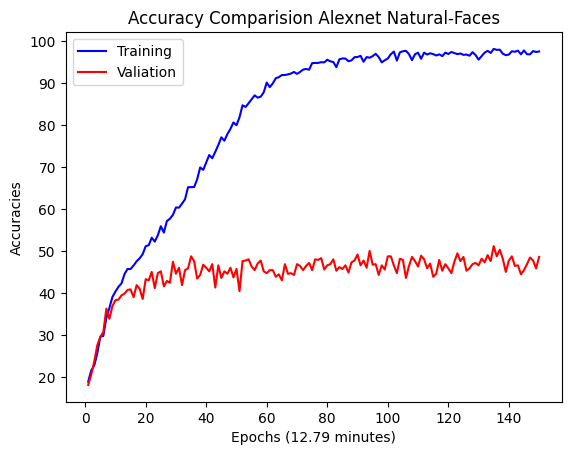

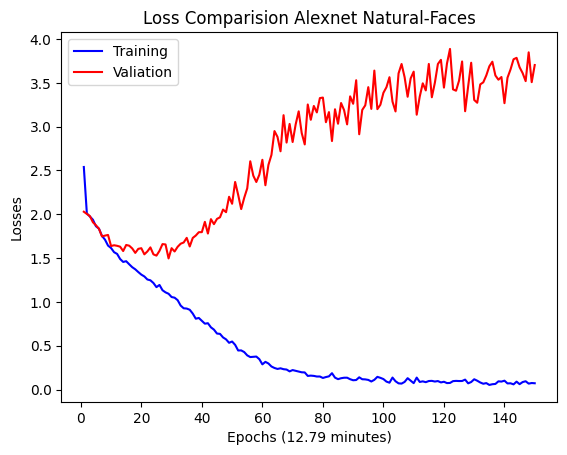

Test Accuracy of the model on the 900 test images: 50.0 %


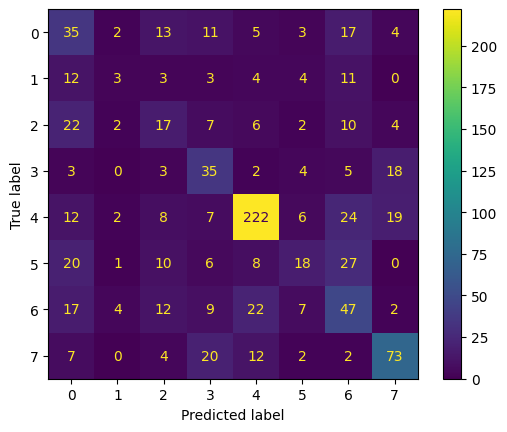

Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


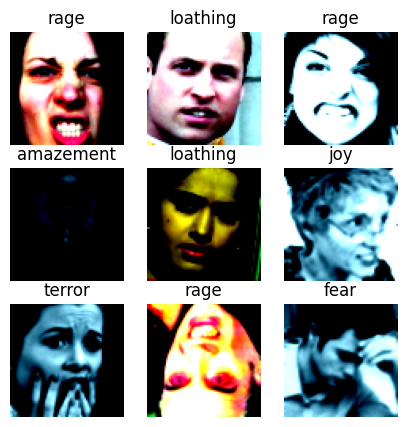

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.5601, Validation Loss: 1.7772, Training Accuracy: 20.75%, Validation Accuracy: 31.1385,
Epoch [2/150], Training Loss: 1.6777, Validation Loss: 1.6075, Training Accuracy: 36.02%, Validation Accuracy: 37.7026,
Epoch [3/150], Training Loss: 1.5370, Validation Loss: 1.5282, Training Accuracy: 41.32%, Validation Accuracy: 41.4769,
Epoch [4/150], Training Loss: 1.4475, Validation Loss: 1.4883, Training Accuracy: 45.23%, Validation Accuracy: 43.4256,
Epoch [5/150], Training Loss: 1.3795, Validation Loss: 1.4859, Training Accuracy: 48.00%, Validation Accuracy: 44.5538,
Epoch [6/150], Training Loss: 1.3187, Validation Loss: 1.4642, Training Accuracy: 50.20%, Validation Accuracy: 45.8462,
Epoch [7/150], Training Loss: 1.2605, Validation Loss: 1.4416, Training Accuracy: 52.52%, Validation Accuracy: 45.7846,
Epoch [8/150], Training Loss: 1.1981, Validation Loss: 1.4482, Training Accuracy: 55.23%, Validation Accuracy: 46.4615,
Epoch [9/

Epoch [69/150], Training Loss: 0.1356, Validation Loss: 2.9663, Training Accuracy: 95.48%, Validation Accuracy: 47.5692,
Epoch [70/150], Training Loss: 0.1293, Validation Loss: 2.9820, Training Accuracy: 95.72%, Validation Accuracy: 47.8564,
Epoch [71/150], Training Loss: 0.1306, Validation Loss: 3.0461, Training Accuracy: 95.74%, Validation Accuracy: 47.5692,
Epoch [72/150], Training Loss: 0.1258, Validation Loss: 3.1688, Training Accuracy: 95.88%, Validation Accuracy: 47.7538,
Epoch [73/150], Training Loss: 0.1335, Validation Loss: 3.2162, Training Accuracy: 95.63%, Validation Accuracy: 46.7077,
Epoch [74/150], Training Loss: 0.1232, Validation Loss: 3.2328, Training Accuracy: 95.91%, Validation Accuracy: 46.6872,
Epoch [75/150], Training Loss: 0.1301, Validation Loss: 3.1738, Training Accuracy: 95.73%, Validation Accuracy: 46.6667,
Epoch [76/150], Training Loss: 0.1199, Validation Loss: 3.3585, Training Accuracy: 96.02%, Validation Accuracy: 45.6205,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0763, Validation Loss: 3.8518, Training Accuracy: 97.49%, Validation Accuracy: 46.7897,
Epoch [138/150], Training Loss: 0.0821, Validation Loss: 3.7188, Training Accuracy: 97.24%, Validation Accuracy: 48.4513,
Epoch [139/150], Training Loss: 0.0831, Validation Loss: 3.4160, Training Accuracy: 97.27%, Validation Accuracy: 47.8564,
Epoch [140/150], Training Loss: 0.0816, Validation Loss: 3.3511, Training Accuracy: 97.35%, Validation Accuracy: 46.4205,
Epoch [141/150], Training Loss: 0.0775, Validation Loss: 3.7187, Training Accuracy: 97.54%, Validation Accuracy: 48.0615,
Epoch [142/150], Training Loss: 0.0783, Validation Loss: 3.6101, Training Accuracy: 97.46%, Validation Accuracy: 47.3026,
Epoch [143/150], Training Loss: 0.0884, Validation Loss: 3.7673, Training Accuracy: 97.23%, Validation Accuracy: 46.3590,
Epoch [144/150], Training Loss: 0.0877, Validation Loss: 3.6006, Training Accuracy: 97.24%, Validation Accuracy: 46.4615,
Epoch [145/150], Trainin

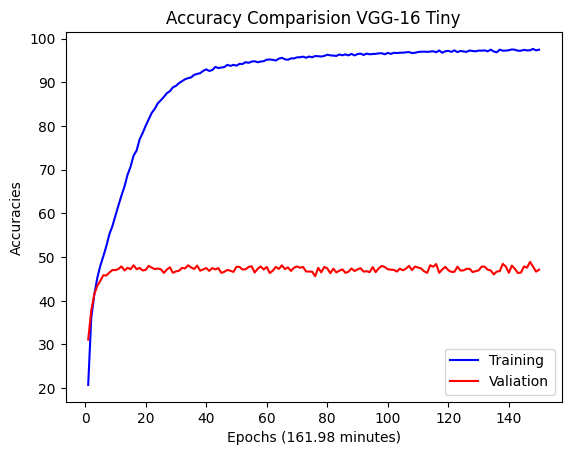

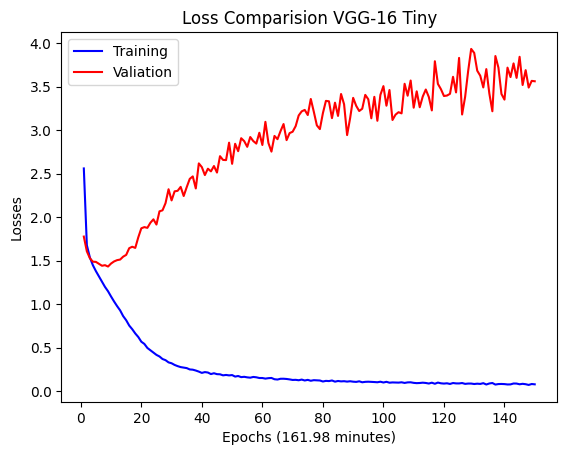

Test Accuracy of the model on the 9837 test images: 52.24153705397987 %


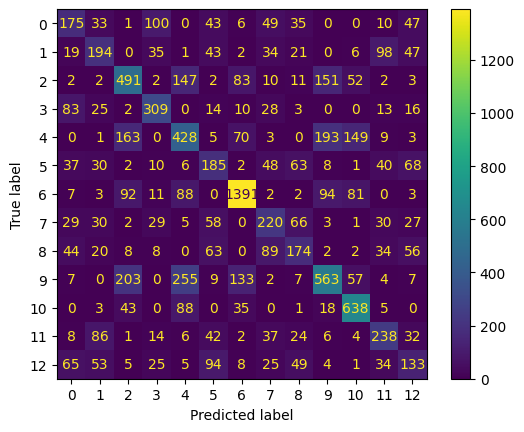

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


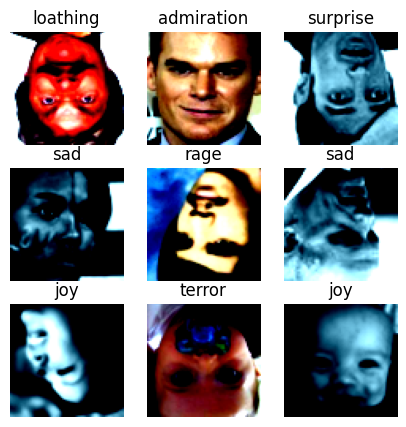

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.4205, Validation Loss: 1.8737, Training Accuracy: 24.46%, Validation Accuracy: 29.9077,
Epoch [2/150], Training Loss: 1.7620, Validation Loss: 1.7716, Training Accuracy: 33.38%, Validation Accuracy: 32.2872,
Epoch [3/150], Training Loss: 1.6682, Validation Loss: 1.7346, Training Accuracy: 37.15%, Validation Accuracy: 34.4615,
Epoch [4/150], Training Loss: 1.5938, Validation Loss: 1.6936, Training Accuracy: 40.17%, Validation Accuracy: 36.6154,
Epoch [5/150], Training Loss: 1.5272, Validation Loss: 1.6851, Training Accuracy: 42.60%, Validation Accuracy: 36.9231,
Epoch [6/150], Training Loss: 1.4645, Validation Loss: 1.6566, Training Accuracy: 44.96%, Validation Accuracy: 39.4667,
Epoch [7/150], Training Loss: 1.4143, Validation Loss: 1.6455, Training Accuracy: 47.29%, Validation Accuracy: 38.5641,
Epoch [8/150], Training Loss: 1.3571, Validation Loss: 1.6143, Training Accuracy: 49.84%, Validation Accuracy: 39.9179,
Epoch [9/

Epoch [69/150], Training Loss: 0.1770, Validation Loss: 3.1682, Training Accuracy: 94.39%, Validation Accuracy: 41.8051,
Epoch [70/150], Training Loss: 0.1762, Validation Loss: 3.1163, Training Accuracy: 94.13%, Validation Accuracy: 42.2154,
Epoch [71/150], Training Loss: 0.1763, Validation Loss: 3.1694, Training Accuracy: 94.16%, Validation Accuracy: 42.3385,
Epoch [72/150], Training Loss: 0.1784, Validation Loss: 3.1301, Training Accuracy: 94.05%, Validation Accuracy: 42.2359,
Epoch [73/150], Training Loss: 0.1669, Validation Loss: 3.1664, Training Accuracy: 94.43%, Validation Accuracy: 41.8872,
Epoch [74/150], Training Loss: 0.1641, Validation Loss: 3.1918, Training Accuracy: 94.57%, Validation Accuracy: 41.9487,
Epoch [75/150], Training Loss: 0.1671, Validation Loss: 3.2153, Training Accuracy: 94.48%, Validation Accuracy: 41.9487,
Epoch [76/150], Training Loss: 0.1671, Validation Loss: 3.1052, Training Accuracy: 94.53%, Validation Accuracy: 42.8513,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0969, Validation Loss: 3.7094, Training Accuracy: 96.87%, Validation Accuracy: 43.2205,
Epoch [138/150], Training Loss: 0.0862, Validation Loss: 3.6326, Training Accuracy: 97.12%, Validation Accuracy: 44.4513,
Epoch [139/150], Training Loss: 0.0988, Validation Loss: 3.7205, Training Accuracy: 96.73%, Validation Accuracy: 42.9949,
Epoch [140/150], Training Loss: 0.0968, Validation Loss: 3.7404, Training Accuracy: 96.69%, Validation Accuracy: 41.8462,
Epoch [141/150], Training Loss: 0.0955, Validation Loss: 3.6933, Training Accuracy: 96.89%, Validation Accuracy: 43.2205,
Epoch [142/150], Training Loss: 0.0942, Validation Loss: 3.7168, Training Accuracy: 96.91%, Validation Accuracy: 42.7077,
Epoch [143/150], Training Loss: 0.0970, Validation Loss: 3.7550, Training Accuracy: 96.70%, Validation Accuracy: 42.4410,
Epoch [144/150], Training Loss: 0.0996, Validation Loss: 3.7239, Training Accuracy: 96.71%, Validation Accuracy: 41.9487,
Epoch [145/150], Trainin

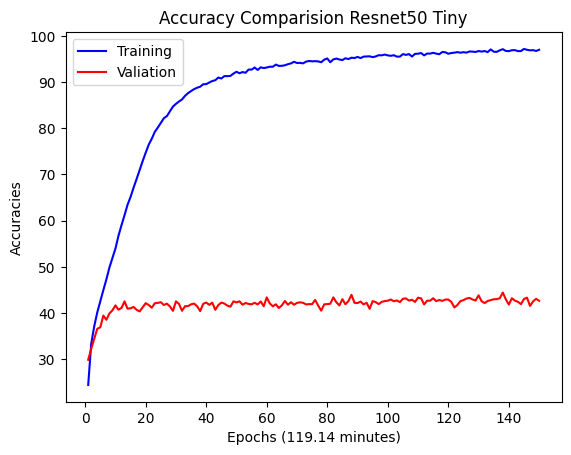

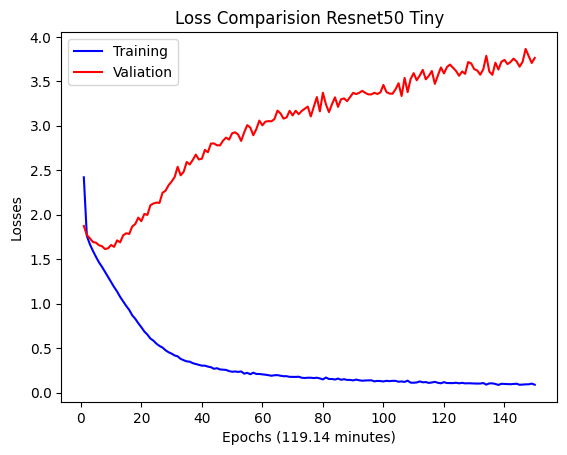

Test Accuracy of the model on the 9837 test images: 46.70123004981194 %


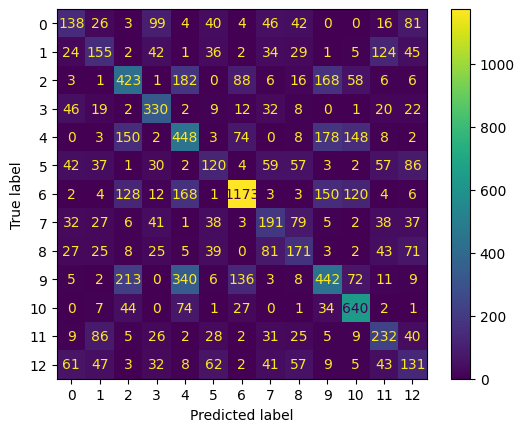

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


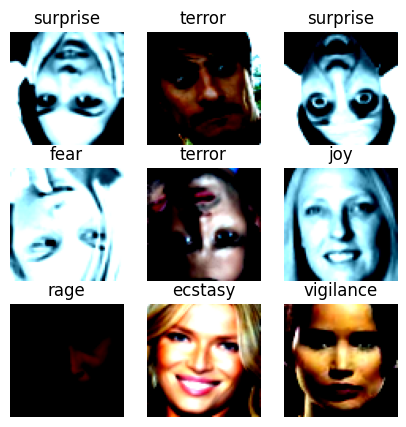

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.4675, Validation Loss: 1.8038, Training Accuracy: 23.06%, Validation Accuracy: 31.3846,
Epoch [2/150], Training Loss: 1.7696, Validation Loss: 1.7121, Training Accuracy: 32.86%, Validation Accuracy: 34.9949,
Epoch [3/150], Training Loss: 1.6945, Validation Loss: 1.6833, Training Accuracy: 35.83%, Validation Accuracy: 35.1590,
Epoch [4/150], Training Loss: 1.6388, Validation Loss: 1.6149, Training Accuracy: 37.78%, Validation Accuracy: 38.2359,
Epoch [5/150], Training Loss: 1.5918, Validation Loss: 1.6196, Training Accuracy: 39.72%, Validation Accuracy: 38.4821,
Epoch [6/150], Training Loss: 1.5543, Validation Loss: 1.5765, Training Accuracy: 40.68%, Validation Accuracy: 39.8154,
Epoch [7/150], Training Loss: 1.5216, Validation Loss: 1.5884, Training Accuracy: 42.44%, Validation Accuracy: 39.9795,
Epoch [8/150], Training Loss: 1.4879, Validation Loss: 1.5525, Training Accuracy: 43.51%, Validation Accuracy: 41.3333,
Epoch [9/

Epoch [69/150], Training Loss: 0.2463, Validation Loss: 3.0365, Training Accuracy: 91.67%, Validation Accuracy: 43.2410,
Epoch [70/150], Training Loss: 0.2453, Validation Loss: 3.0508, Training Accuracy: 91.63%, Validation Accuracy: 43.5692,
Epoch [71/150], Training Loss: 0.2417, Validation Loss: 3.0376, Training Accuracy: 91.75%, Validation Accuracy: 43.1795,
Epoch [72/150], Training Loss: 0.2251, Validation Loss: 3.1608, Training Accuracy: 92.37%, Validation Accuracy: 43.9795,
Epoch [73/150], Training Loss: 0.2286, Validation Loss: 3.1896, Training Accuracy: 92.11%, Validation Accuracy: 43.3026,
Epoch [74/150], Training Loss: 0.2228, Validation Loss: 3.1264, Training Accuracy: 92.36%, Validation Accuracy: 42.9538,
Epoch [75/150], Training Loss: 0.2256, Validation Loss: 3.0982, Training Accuracy: 92.17%, Validation Accuracy: 42.2154,
Epoch [76/150], Training Loss: 0.2202, Validation Loss: 3.2280, Training Accuracy: 92.59%, Validation Accuracy: 42.6051,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.1186, Validation Loss: 4.1107, Training Accuracy: 96.16%, Validation Accuracy: 42.7692,
Epoch [138/150], Training Loss: 0.1217, Validation Loss: 3.9907, Training Accuracy: 95.79%, Validation Accuracy: 43.5897,
Epoch [139/150], Training Loss: 0.1180, Validation Loss: 4.0408, Training Accuracy: 96.03%, Validation Accuracy: 44.0410,
Epoch [140/150], Training Loss: 0.1253, Validation Loss: 4.0230, Training Accuracy: 95.89%, Validation Accuracy: 43.0564,
Epoch [141/150], Training Loss: 0.1162, Validation Loss: 3.9702, Training Accuracy: 96.17%, Validation Accuracy: 43.5282,
Epoch [142/150], Training Loss: 0.1169, Validation Loss: 4.0348, Training Accuracy: 96.02%, Validation Accuracy: 44.1026,
Epoch [143/150], Training Loss: 0.1114, Validation Loss: 4.1739, Training Accuracy: 96.28%, Validation Accuracy: 42.5231,
Epoch [144/150], Training Loss: 0.1127, Validation Loss: 3.7668, Training Accuracy: 96.26%, Validation Accuracy: 42.8923,
Epoch [145/150], Trainin

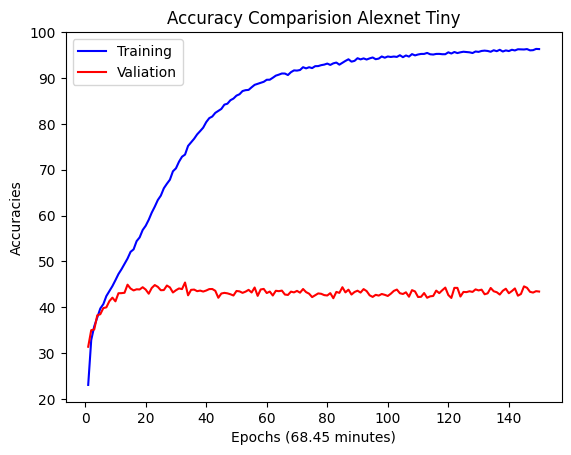

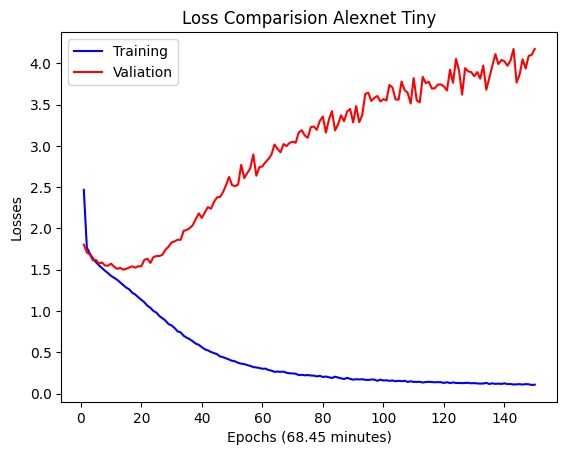

Test Accuracy of the model on the 9837 test images: 46.91470976923859 %


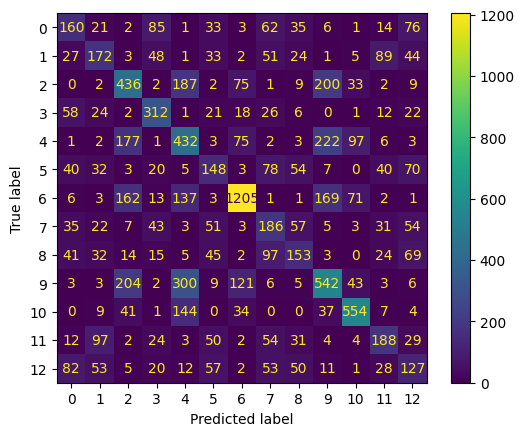

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


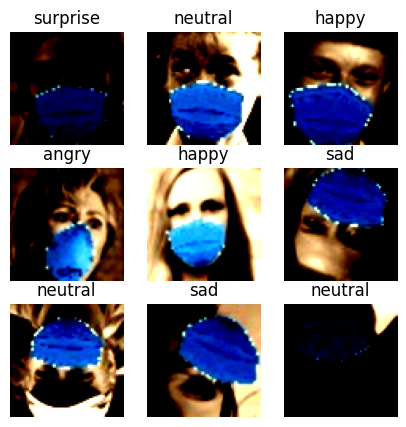

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.5441, Validation Loss: 1.0374, Training Accuracy: 41.33%, Validation Accuracy: 52.3011,
Epoch [2/150], Training Loss: 0.9670, Validation Loss: 0.9212, Training Accuracy: 55.85%, Validation Accuracy: 57.5273,
Epoch [3/150], Training Loss: 0.8908, Validation Loss: 0.9136, Training Accuracy: 60.46%, Validation Accuracy: 58.8144,
Epoch [4/150], Training Loss: 0.8318, Validation Loss: 0.8472, Training Accuracy: 63.69%, Validation Accuracy: 62.6365,
Epoch [5/150], Training Loss: 0.7642, Validation Loss: 0.8439, Training Accuracy: 67.69%, Validation Accuracy: 62.9095,
Epoch [6/150], Training Loss: 0.7189, Validation Loss: 0.8850, Training Accuracy: 70.42%, Validation Accuracy: 62.2855,
Epoch [7/150], Training Loss: 0.6818, Validation Loss: 0.8218, Training Accuracy: 72.34%, Validation Accuracy: 65.8736,
Epoch [8/150], Training Loss: 0.6572, Validation Loss: 0.8852, Training Accuracy: 73.92%, Validation Accuracy: 65.1326,
Epoch [9/

Epoch [69/150], Training Loss: 0.0592, Validation Loss: 1.7945, Training Accuracy: 98.05%, Validation Accuracy: 68.3307,
Epoch [70/150], Training Loss: 0.0480, Validation Loss: 1.9098, Training Accuracy: 98.43%, Validation Accuracy: 67.2387,
Epoch [71/150], Training Loss: 0.0465, Validation Loss: 2.1124, Training Accuracy: 98.45%, Validation Accuracy: 67.2777,
Epoch [72/150], Training Loss: 0.0523, Validation Loss: 1.8526, Training Accuracy: 98.33%, Validation Accuracy: 69.0718,
Epoch [73/150], Training Loss: 0.0356, Validation Loss: 2.0616, Training Accuracy: 98.73%, Validation Accuracy: 67.9797,
Epoch [74/150], Training Loss: 0.0436, Validation Loss: 1.7307, Training Accuracy: 98.53%, Validation Accuracy: 68.0967,
Epoch [75/150], Training Loss: 0.0430, Validation Loss: 1.8975, Training Accuracy: 98.62%, Validation Accuracy: 67.2387,
Epoch [76/150], Training Loss: 0.0459, Validation Loss: 1.8231, Training Accuracy: 98.66%, Validation Accuracy: 67.4727,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0381, Validation Loss: 2.1859, Training Accuracy: 98.75%, Validation Accuracy: 68.4477,
Epoch [138/150], Training Loss: 0.0254, Validation Loss: 2.4417, Training Accuracy: 99.21%, Validation Accuracy: 66.4197,
Epoch [139/150], Training Loss: 0.0357, Validation Loss: 2.4191, Training Accuracy: 98.71%, Validation Accuracy: 68.0967,
Epoch [140/150], Training Loss: 0.0208, Validation Loss: 2.5455, Training Accuracy: 99.37%, Validation Accuracy: 68.7598,
Epoch [141/150], Training Loss: 0.0483, Validation Loss: 2.0801, Training Accuracy: 98.59%, Validation Accuracy: 66.9267,
Epoch [142/150], Training Loss: 0.0688, Validation Loss: 2.2374, Training Accuracy: 97.73%, Validation Accuracy: 67.7067,
Epoch [143/150], Training Loss: 0.0334, Validation Loss: 2.0986, Training Accuracy: 98.94%, Validation Accuracy: 67.0047,
Epoch [144/150], Training Loss: 0.0306, Validation Loss: 2.1374, Training Accuracy: 99.13%, Validation Accuracy: 66.9267,
Epoch [145/150], Trainin

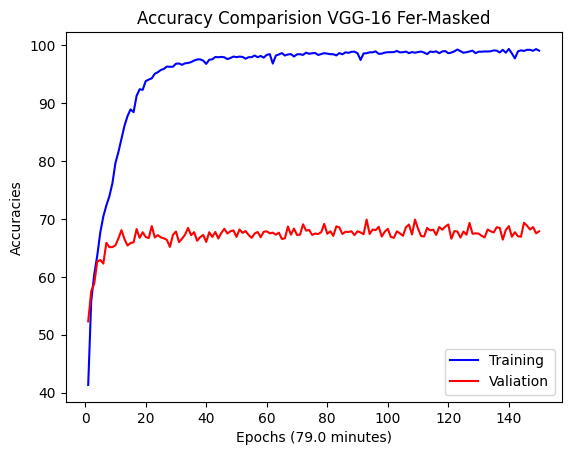

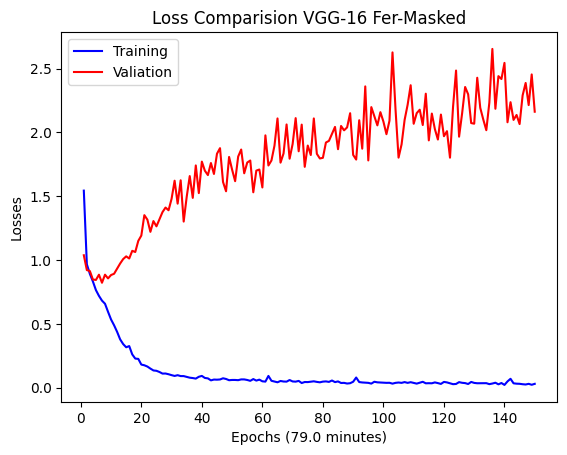

Test Accuracy of the model on the 4250 test images: 52.21176470588236 %


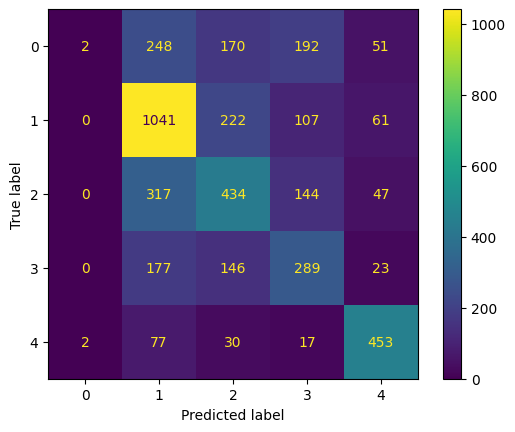

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


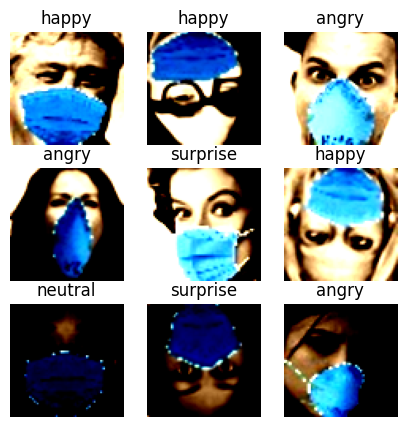

Device: cuda:0
Total Steps 228


KeyboardInterrupt: 

In [10]:

train_paths=['C:/Datasets/Datasets/Natural-Faces/train','C:/Datasets/Datasets/tiny/train','C:/Datasets/Datasets/Masked-fer2013/train']
test_paths=['C:/Datasets/Datasets/Natural-Faces/test','C:/Datasets/Datasets/tiny/test','C:/Datasets/Datasets/Masked-fer2013/test']

mdl_path='C:/Datasets/Datasets/Models/'
img_path='C:/Datasets/Datasets/Images/'  # CHANGE ALL 4 PATHS BASED ON UR FOLDER LOCATIONS (FOR MODEL/IMG PATH MAKE SURE TO CREATE FOLDERS)

mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666]]


batch_size=64
image_size=(72,72)
num_epochs=150
learning_rate=0.0001

dtaname=['Natural-Faces','Tiny','Fer-Masked']

# mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mobilenet_v3_small(),torchvision.models.mobilenet_v2(),torchvision.models.mnasnet0_5()]
# mdlname=['Shufflnet','MobileNetV3','MobileNetv2','MnasNet'] 

mdls=[torchvision.models.vgg16(weights=False),torchvision.models.resnet50(weights=False),torchvision.models.alexnet(weights= None)]  # CHANGE THIS ACCORDING TO NEED
mdlname=['VGG-16','Resnet50','Alexnet'] # UPDATE BASED ON LIST ABOVE



for i in range(0,len(train_paths)):
    for k in range (0,len(mdls)):
        
        train_folder=train_paths[i]
        test_folder=test_paths[i]
        train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        # print('----------PARAMETERS----------') #PRINTING MODEL AND NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        # summary(model, (3,48,48))
        # print('----------FLOPS----------')
        # count_ops(model, torch.rand(1,3,48,48).to(device))
        
        
        model,t_acc,v_acc,t_loss,v_loss,epc,time_taken=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        
        time_taken=round((time_taken/60),2)
        title=mdlname[k]+' '+dtaname[i]
        grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Losses','Loss Comparision '+title,img_path)
    
        test_model(model,test_loader)  # TESTING MODEL
        torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 

    
    
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


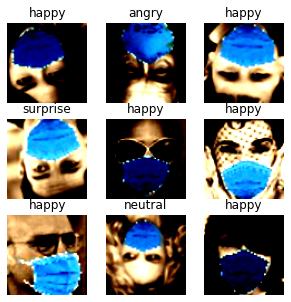

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.7157, Validation Loss: 1.4515, Training Accuracy: 32.73%, Validation Accuracy: 38.2605,
Epoch [2/150], Training Loss: 1.3296, Validation Loss: 1.2218, Training Accuracy: 41.65%, Validation Accuracy: 46.8019,
Epoch [3/150], Training Loss: 1.1808, Validation Loss: 1.1671, Training Accuracy: 47.24%, Validation Accuracy: 45.8658,
Epoch [4/150], Training Loss: 1.1313, Validation Loss: 1.1229, Training Accuracy: 48.96%, Validation Accuracy: 48.4399,
Epoch [5/150], Training Loss: 1.0814, Validation Loss: 1.0886, Training Accuracy: 51.02%, Validation Accuracy: 51.6771,
Epoch [6/150], Training Loss: 1.0496, Validation Loss: 1.0852, Training Accuracy: 51.96%, Validation Accuracy: 52.5741,
Epoch [7/150], Training Loss: 1.0223, Validation Loss: 1.0715, Training Accuracy: 52.77%, Validation Accuracy: 48.3229,
Epoch [8/150], Training Loss: 0.9976, Validation Loss: 1.0599, Training Accuracy: 54.59%, Validation Accuracy: 53.5881,
Epoch [9/

Epoch [69/150], Training Loss: 0.1955, Validation Loss: 1.5446, Training Accuracy: 93.06%, Validation Accuracy: 61.7005,
Epoch [70/150], Training Loss: 0.1987, Validation Loss: 1.4862, Training Accuracy: 93.11%, Validation Accuracy: 63.8456,
Epoch [71/150], Training Loss: 0.2014, Validation Loss: 1.4772, Training Accuracy: 93.17%, Validation Accuracy: 62.0515,
Epoch [72/150], Training Loss: 0.2543, Validation Loss: 1.5568, Training Accuracy: 90.39%, Validation Accuracy: 60.9204,
Epoch [73/150], Training Loss: 0.1736, Validation Loss: 1.6521, Training Accuracy: 94.00%, Validation Accuracy: 60.8034,
Epoch [74/150], Training Loss: 0.2313, Validation Loss: 1.5334, Training Accuracy: 91.57%, Validation Accuracy: 63.6895,
Epoch [75/150], Training Loss: 0.1573, Validation Loss: 1.5630, Training Accuracy: 94.23%, Validation Accuracy: 62.0125,
Epoch [76/150], Training Loss: 0.2209, Validation Loss: 1.6606, Training Accuracy: 92.04%, Validation Accuracy: 61.2715,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.1183, Validation Loss: 1.7852, Training Accuracy: 95.81%, Validation Accuracy: 63.1435,
Epoch [138/150], Training Loss: 0.0704, Validation Loss: 1.8174, Training Accuracy: 97.56%, Validation Accuracy: 63.2605,
Epoch [139/150], Training Loss: 0.0666, Validation Loss: 1.9682, Training Accuracy: 97.69%, Validation Accuracy: 63.1825,
Epoch [140/150], Training Loss: 0.0583, Validation Loss: 1.9703, Training Accuracy: 97.99%, Validation Accuracy: 63.5725,
Epoch [141/150], Training Loss: 0.0908, Validation Loss: 1.8922, Training Accuracy: 97.27%, Validation Accuracy: 63.2605,
Epoch [142/150], Training Loss: 0.1123, Validation Loss: 1.7694, Training Accuracy: 96.07%, Validation Accuracy: 64.2746,
Epoch [143/150], Training Loss: 0.0954, Validation Loss: 1.9440, Training Accuracy: 97.62%, Validation Accuracy: 62.8705,
Epoch [144/150], Training Loss: 0.1544, Validation Loss: 1.7691, Training Accuracy: 95.10%, Validation Accuracy: 63.2605,
Epoch [145/150], Trainin

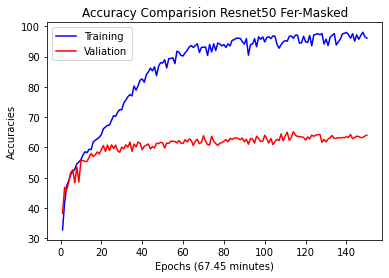

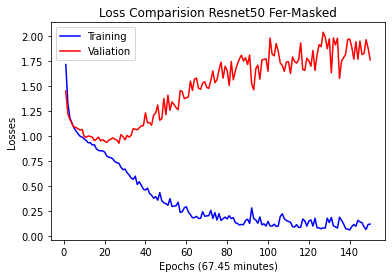

Test Accuracy of the model on the 4250 test images: 48.964705882352945 %


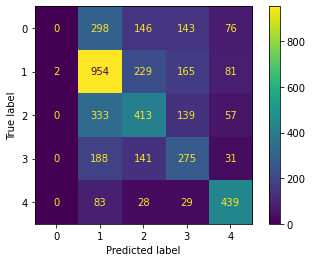

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


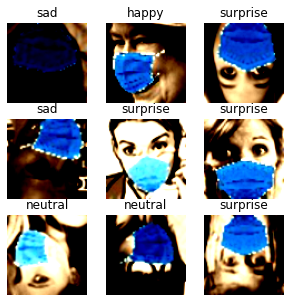

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.6966, Validation Loss: 1.5102, Training Accuracy: 29.37%, Validation Accuracy: 36.1544,
Epoch [2/150], Training Loss: 1.1664, Validation Loss: 1.1480, Training Accuracy: 46.23%, Validation Accuracy: 47.9329,
Epoch [3/150], Training Loss: 1.0623, Validation Loss: 1.0776, Training Accuracy: 50.93%, Validation Accuracy: 51.5601,
Epoch [4/150], Training Loss: 1.0182, Validation Loss: 1.0278, Training Accuracy: 52.38%, Validation Accuracy: 52.9251,
Epoch [5/150], Training Loss: 0.9965, Validation Loss: 1.0257, Training Accuracy: 53.69%, Validation Accuracy: 50.1170,
Epoch [6/150], Training Loss: 0.9849, Validation Loss: 0.9904, Training Accuracy: 54.27%, Validation Accuracy: 55.1092,
Epoch [7/150], Training Loss: 0.9593, Validation Loss: 0.9788, Training Accuracy: 55.38%, Validation Accuracy: 55.3432,
Epoch [8/150], Training Loss: 0.9529, Validation Loss: 0.9680, Training Accuracy: 56.15%, Validation Accuracy: 56.7863,
Epoch [9/

Epoch [69/150], Training Loss: 0.2653, Validation Loss: 1.4955, Training Accuracy: 90.23%, Validation Accuracy: 62.9485,
Epoch [70/150], Training Loss: 0.2190, Validation Loss: 1.3968, Training Accuracy: 91.71%, Validation Accuracy: 64.3916,
Epoch [71/150], Training Loss: 0.2197, Validation Loss: 1.4973, Training Accuracy: 91.65%, Validation Accuracy: 62.3245,
Epoch [72/150], Training Loss: 0.2028, Validation Loss: 1.5588, Training Accuracy: 92.55%, Validation Accuracy: 64.3136,
Epoch [73/150], Training Loss: 0.2069, Validation Loss: 1.4168, Training Accuracy: 92.29%, Validation Accuracy: 65.0936,
Epoch [74/150], Training Loss: 0.2045, Validation Loss: 1.5169, Training Accuracy: 92.53%, Validation Accuracy: 63.9236,
Epoch [75/150], Training Loss: 0.1976, Validation Loss: 1.5516, Training Accuracy: 93.01%, Validation Accuracy: 63.8846,
Epoch [76/150], Training Loss: 0.2069, Validation Loss: 1.5831, Training Accuracy: 92.15%, Validation Accuracy: 63.9626,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0706, Validation Loss: 2.1122, Training Accuracy: 97.74%, Validation Accuracy: 64.6256,
Epoch [138/150], Training Loss: 0.1252, Validation Loss: 1.9227, Training Accuracy: 95.69%, Validation Accuracy: 62.9875,
Epoch [139/150], Training Loss: 0.0712, Validation Loss: 2.0385, Training Accuracy: 97.61%, Validation Accuracy: 63.9626,
Epoch [140/150], Training Loss: 0.0614, Validation Loss: 2.0813, Training Accuracy: 97.83%, Validation Accuracy: 65.6006,
Epoch [141/150], Training Loss: 0.0483, Validation Loss: 2.3219, Training Accuracy: 98.34%, Validation Accuracy: 65.9126,
Epoch [142/150], Training Loss: 0.0606, Validation Loss: 2.2231, Training Accuracy: 97.98%, Validation Accuracy: 65.8736,
Epoch [143/150], Training Loss: 0.0598, Validation Loss: 2.2240, Training Accuracy: 97.83%, Validation Accuracy: 64.0016,
Epoch [144/150], Training Loss: 0.0653, Validation Loss: 2.1605, Training Accuracy: 97.67%, Validation Accuracy: 64.3136,
Epoch [145/150], Trainin

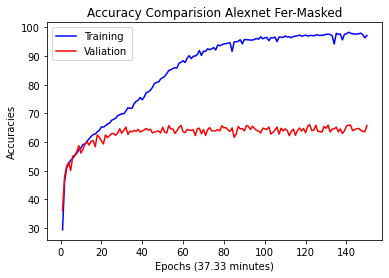

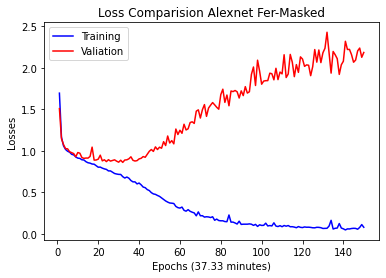

Test Accuracy of the model on the 4250 test images: 48.94117647058824 %


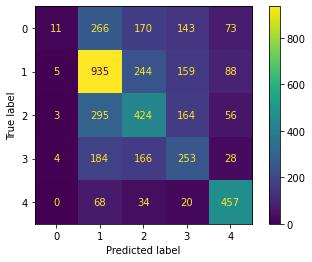

In [9]:

train_paths=['C:/Datasets/Datasets/Natural-Faces/train','C:/Datasets/Datasets/tiny/train','C:/Datasets/Datasets/Masked-fer2013/train']
test_paths=['C:/Datasets/Datasets/Natural-Faces/test','C:/Datasets/Datasets/tiny/test','C:/Datasets/Datasets/Masked-fer2013/test']

mdl_path='C:/Datasets/Datasets/Models/'
img_path='C:/Datasets/Datasets/Images/'  # CHANGE ALL 4 PATHS BASED ON UR FOLDER LOCATIONS (FOR MODEL/IMG PATH MAKE SURE TO CREATE FOLDERS)

mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666]]


batch_size=64
image_size=(72,72)
num_epochs=150
learning_rate=0.0001

dtaname=['Natural-Faces','Tiny','Fer-Masked']

# mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mobilenet_v3_small(),torchvision.models.mobilenet_v2(),torchvision.models.mnasnet0_5()]
# mdlname=['Shufflnet','MobileNetV3','MobileNetv2','MnasNet'] 

mdls=[torchvision.models.vgg16(weights=False),torchvision.models.resnet50(weights=False),torchvision.models.alexnet(weights= None)]  # CHANGE THIS ACCORDING TO NEED
mdlname=['VGG-16','Resnet50','Alexnet'] # UPDATE BASED ON LIST ABOVE



for i in range(2,len(train_paths)):
    for k in range (1,len(mdls)):
        
        train_folder=train_paths[i]
        test_folder=test_paths[i]
        train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        # print('----------PARAMETERS----------') #PRINTING MODEL AND NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        # summary(model, (3,48,48))
        # print('----------FLOPS----------')
        # count_ops(model, torch.rand(1,3,48,48).to(device))
        
        
        model,t_acc,v_acc,t_loss,v_loss,epc,time_taken=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        
        time_taken=round((time_taken/60),2)
        title=mdlname[k]+' '+dtaname[i]
        grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Losses','Loss Comparision '+title,img_path)
    
        test_model(model,test_loader)  # TESTING MODEL
        torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 


In [15]:

train_paths=['C:/Datasets/Datasets/Natural-Faces/train','C:/Datasets/Datasets/tiny/train','C:/Datasets/Datasets/Masked-fer2013/train']
test_paths=['C:/Datasets/Datasets/Natural-Faces/test','C:/Datasets/Datasets/tiny/test','C:/Datasets/Datasets/Masked-fer2013/test']

mdl_path='C:/Datasets/Datasets/Models/'
img_path='C:/Datasets/Datasets/Images/'  # CHANGE ALL 4 PATHS BASED ON UR FOLDER LOCATIONS (FOR MODEL/IMG PATH MAKE SURE TO CREATE FOLDERS)

mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666]]


batch_size=64
image_size=(72,72)
num_epochs=150
learning_rate=0.0001

dtaname=['Natural-Faces','Tiny','Fer-Masked']

# mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mobilenet_v3_small(),torchvision.models.mobilenet_v2(),torchvision.models.mnasnet0_5()]
# mdlname=['Shufflnet','MobileNetV3','MobileNetv2','MnasNet'] 

mdls=[torchvision.models.vgg16(weights=False),torchvision.models.resnet50(weights=False),torchvision.models.alexnet(weights= None)]  # CHANGE THIS ACCORDING TO NEED
mdlname=['VGG-16','Resnet50','Alexnet'] # UPDATE BASED ON LIST ABOVE



#for i in range(0,len(train_paths)):
for k in range (0,len(mdls)):
        
        #train_folder=train_paths[i]
        #test_folder=test_paths[i]
        #train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        #img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        print('----------PARAMETERS----------') #PRINTING MODEL AND NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        summary(model, (3,72,72))
        print('----------FLOPS----------')
        count_ops(model, torch.rand(1,3,72,72).to(device))
        
        
       # model,t_acc,v_acc,t_loss,v_loss,epc,time_taken=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        
        #time_taken=round((time_taken/60),2)
        #title=mdlname[k]+' '+dtaname[i]
        #grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        #grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Losses','Loss Comparision '+title,img_path)
    
        #test_model(model,test_loader)  # TESTING MODEL
        #torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 


Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 72, 72]          1,792
|    └─ReLU: 2-2                         [-1, 64, 72, 72]          --
|    └─Conv2d: 2-3                       [-1, 64, 72, 72]          36,928
|    └─ReLU: 2-4                         [-1, 64, 72, 72]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 36, 36]          --
|    └─Conv2d: 2-6                       [-1, 128, 36, 36]         73,856
|    └─ReLU: 2-7                         [-1, 128, 36, 36]         --
|    └─Conv2d: 2-8                       [-1, 128, 36, 36]         147,584
|    └─ReLU: 2-9                         [-1, 128, 36, 36]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 18, 18]         --
|    └─Conv2d: 2-11                      [-1, 256, 18, 18]         295,168
|    └─ReLU: 2-12 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 17, 17]          23,296
|    └─ReLU: 2-2                         [-1, 64, 17, 17]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 192, 8, 8]           307,392
|    └─ReLU: 2-5                         [-1, 192, 8, 8]           --
|    └─MaxPool2d: 2-6                    [-1, 192, 3, 3]           --
|    └─Conv2d: 2-7                       [-1, 384, 3, 3]           663,936
|    └─ReLU: 2-8                         [-1, 384, 3, 3]           --
|    └─Conv2d: 2-9                       [-1, 256, 3, 3]           884,992
|    └─ReLU: 2-10                        [-1, 256, 3, 3]           --
|    └─Conv2d: 2-11                      [-1, 256, 3, 3]           590,080
|    └─ReLU: 2-12                        [-1, 256, 3, 3]     